In [1]:
import os
from pyspark import SparkConf, SparkContext
import jieba
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud
import numpy as np
from PIL import Image

In [2]:
# 配置spark
conf = SparkConf().setMaster("local").setAppName("lab2")
sc = SparkContext(conf=conf)

# 读取停用词文件
stopWords_filePath = "src/stop_words.txt"
with open(stopWords_filePath, "r", encoding="utf-8") as file:
    stopWords = [line.strip() for line in file.readlines()]

# 读取文本内容并进行分词
data_filePath = "file:///home/ecs-user/Big-Data_Course_Resources/Lab/Lab2_WordCount/src/data.txt"
dataRdd = sc.textFile(data_filePath)
text = dataRdd.reduce(lambda a, b: a + " " + b)
words_list = jieba.lcut(text)

# 创建RDD并进行词频统计
wordsRdd = sc.parallelize(words_list)
resRdd = wordsRdd.filter(lambda word: word not in stopWords) \
    .filter(lambda word: len(word) > 1) \
        .map(lambda word: (word, 1)) \
            .reduceByKey(lambda a, b: a + b) \
                .sortBy(lambda x: x[1], ascending=False)


Building prefix dict from the default dictionary ...                            
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.760 seconds.
Prefix dict has been built successfully.


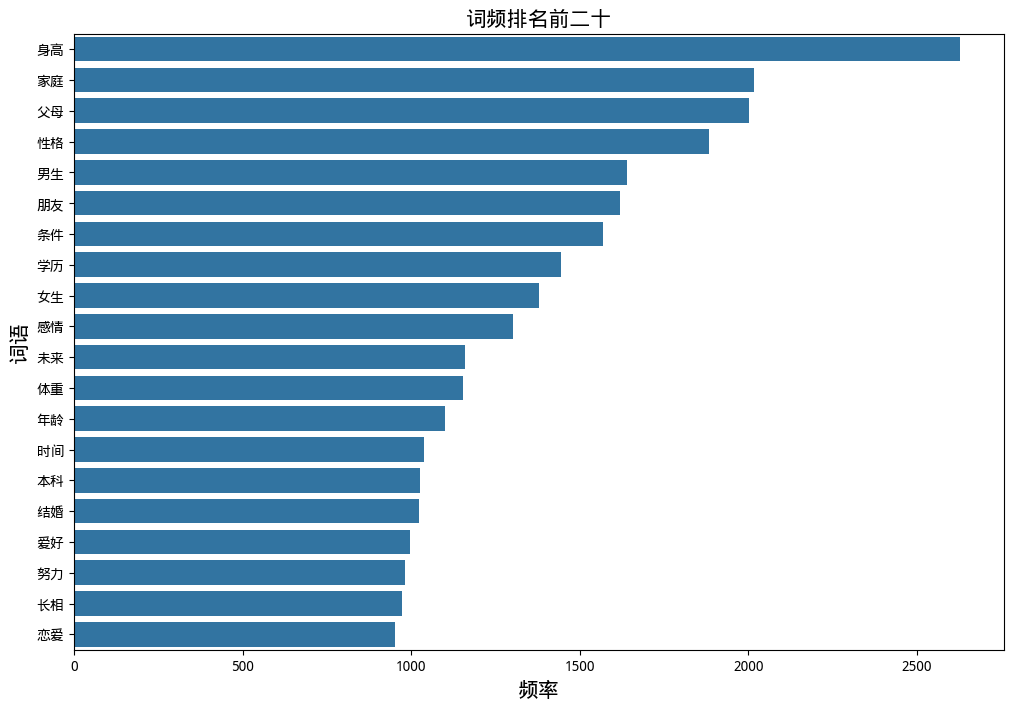

In [3]:
# 设置中文字体
font_name = "WenQuanYi Micro Hei"
plt.rcParams['font.family']= font_name # 指定字体，实际上相当于修改 matplotlibrc 文件　只不过这样做是暂时的　下次失效
plt.rcParams['axes.unicode_minus']=False # 正确显示负号，防止变成方框

# 绘制词频直方图，展示前20个词语的词频分布
top20 = resRdd.take(20)
words, frequencies = zip(*top20)
plt.figure(figsize=(12, 8))
sns.barplot(y=list(words), x=list(frequencies))
plt.title("词频排名前二十", fontsize=15)
plt.xlabel("频率", fontsize=15)
plt.ylabel("词语", fontsize=15)
plt.show()

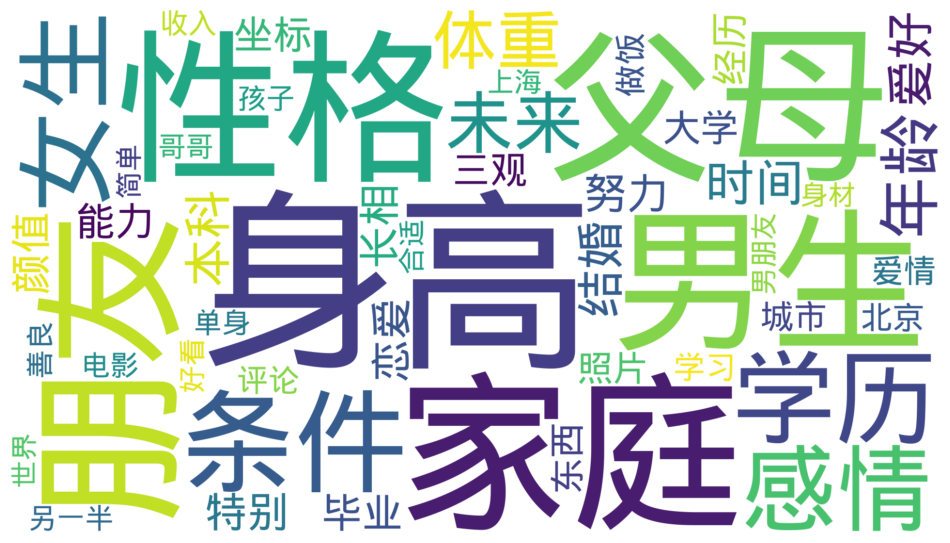

In [4]:
# 词云生成
top50 = resRdd.take(50)
wc = WordCloud(font_path="/home/ecs-user/anaconda3/envs/big_data_lab_env/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/wqy-microhei.ttc",
               background_color="white", 
               width=1920, height=1080, 
               max_words=2000, 
               margin=5)
wc.generate_from_frequencies(dict(top50))
plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()